# Neural Networks Homework Assignment - ECG Beat classification using Convolutional Neural Networks (CNN)

The goal of this project is to classify ECG heat beats using convolutional neural networks (CNN's).

Data Source: 
    - MIT-BIH: The Massachusetts Institute of Technology – Beth Israel Hospital Arrhythmia Database
        - 48 records of 30 min each
        - Download from PhysioNet (https://physionet.org/physiobank/database/#ecg)

**Heart beat - the fiducial points (Source: Wikipedia):**



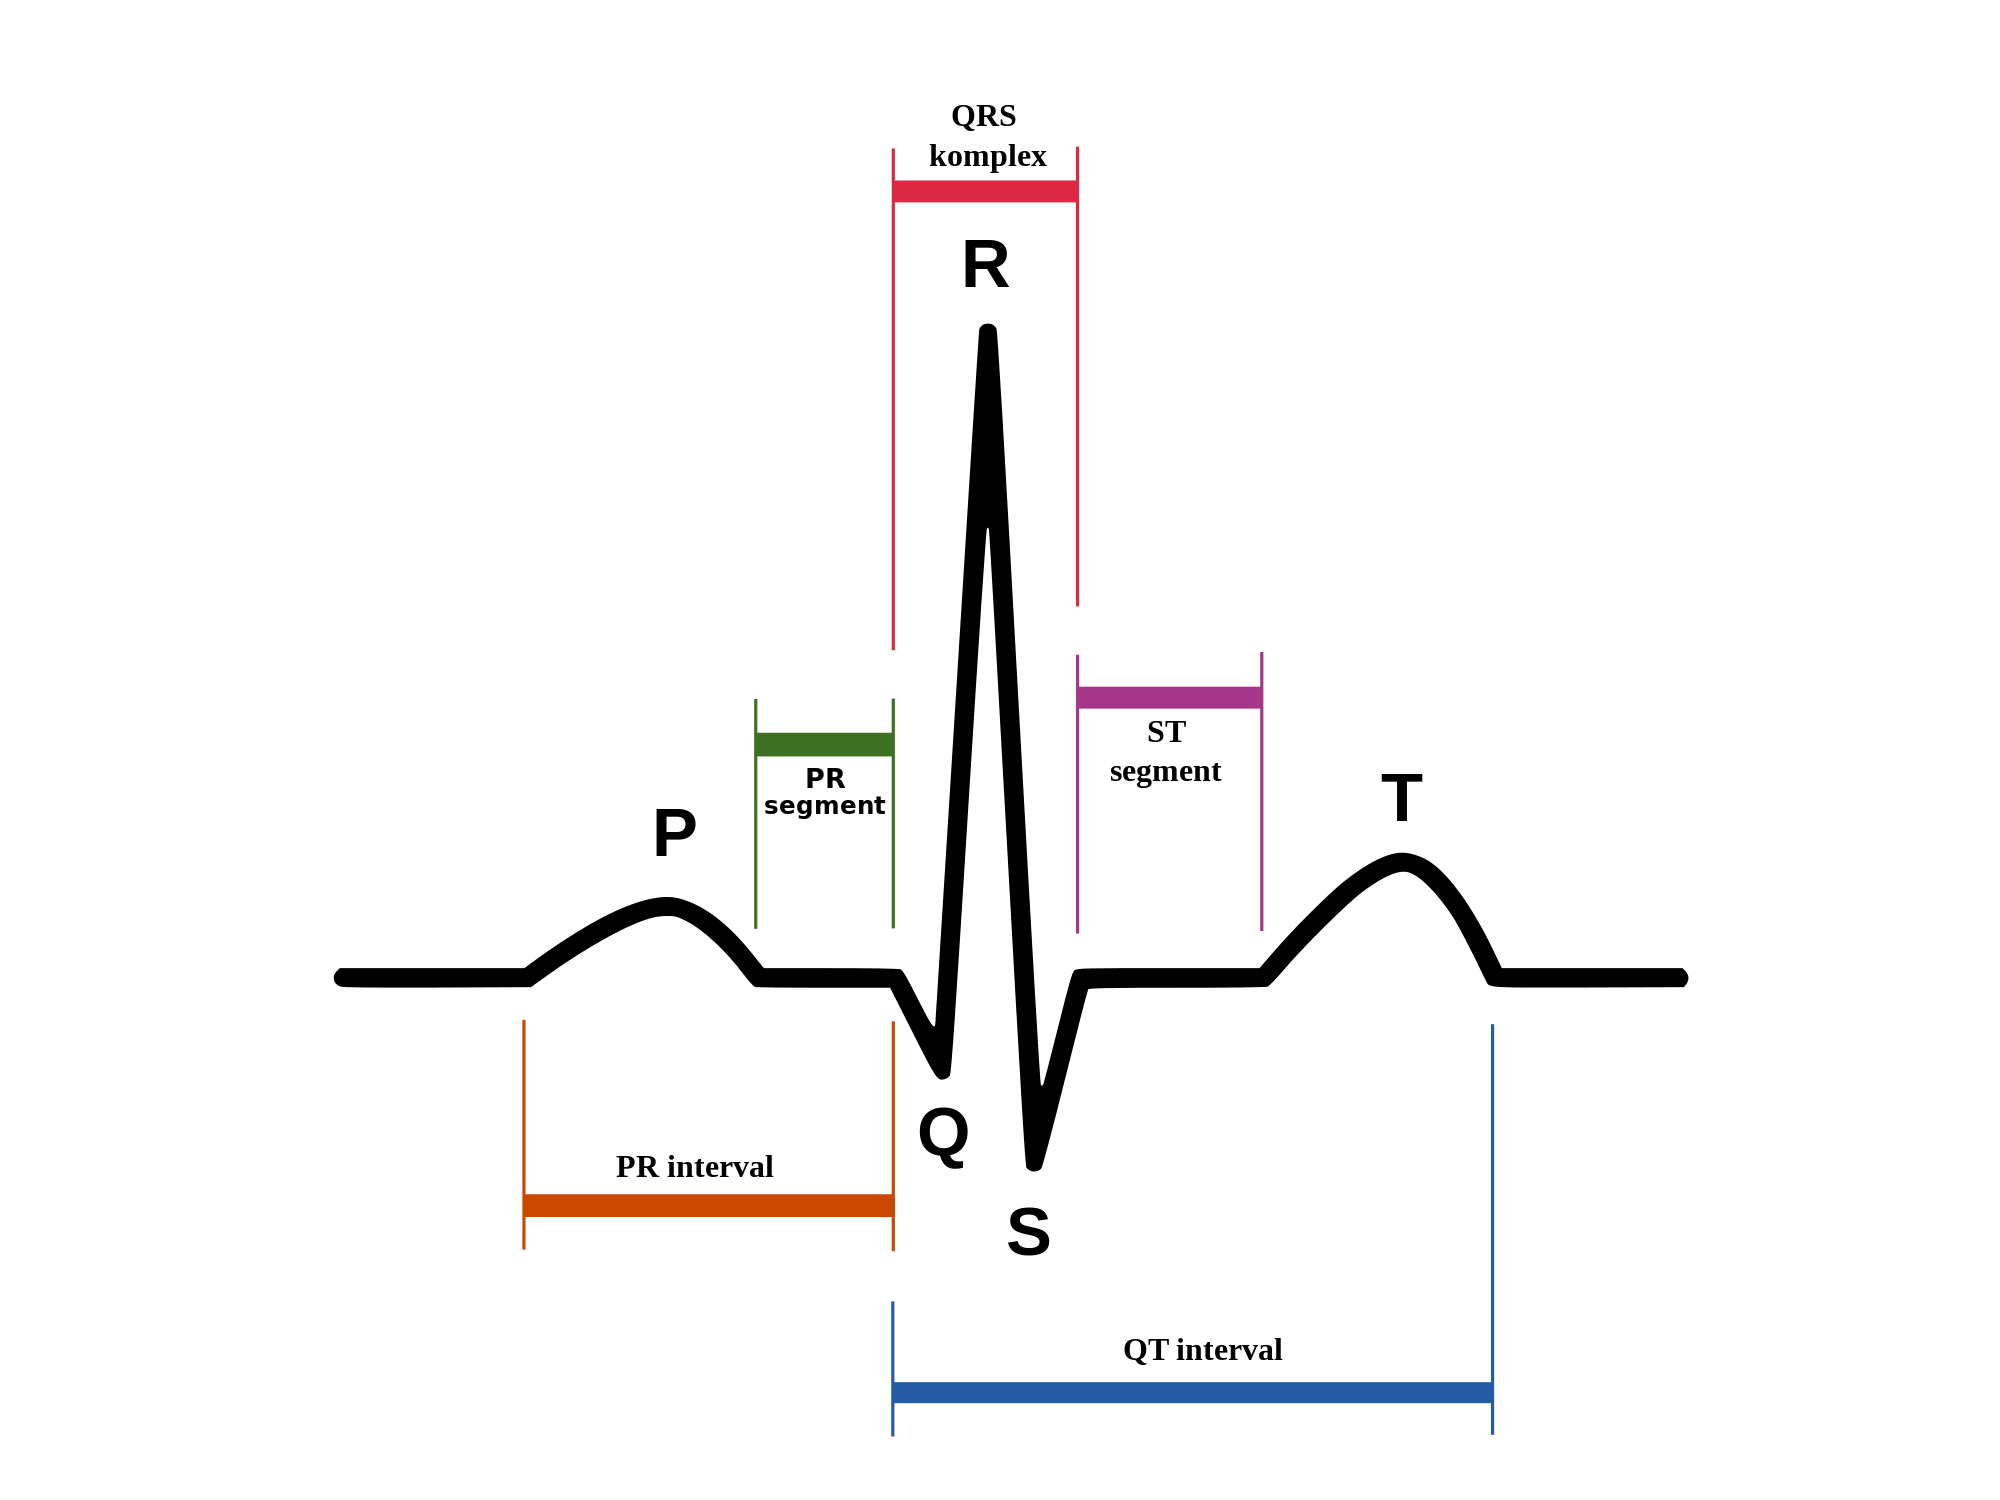

In [6]:
from IPython.display import Image
basewidth = 650
Image("img/PQRST.png", width="650")

**Types of heartbeats to be classified :** 

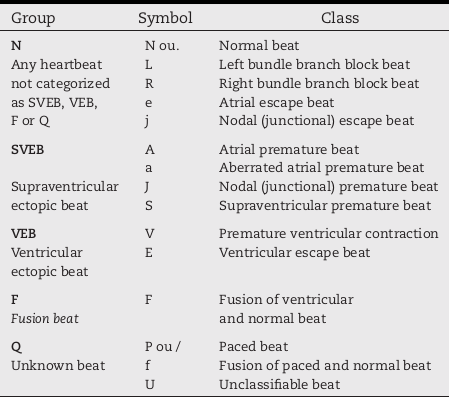

In [8]:
from IPython.display import Image
basewidth = 650
Image("img/beat_types.png", width="450")

 (Source: "ECG-based heartbeat classification for arrhythmia detection: A survey", da S. Luz, Schwartz,Cámara-Chávez, Menotti)

**Plan of procedure: **

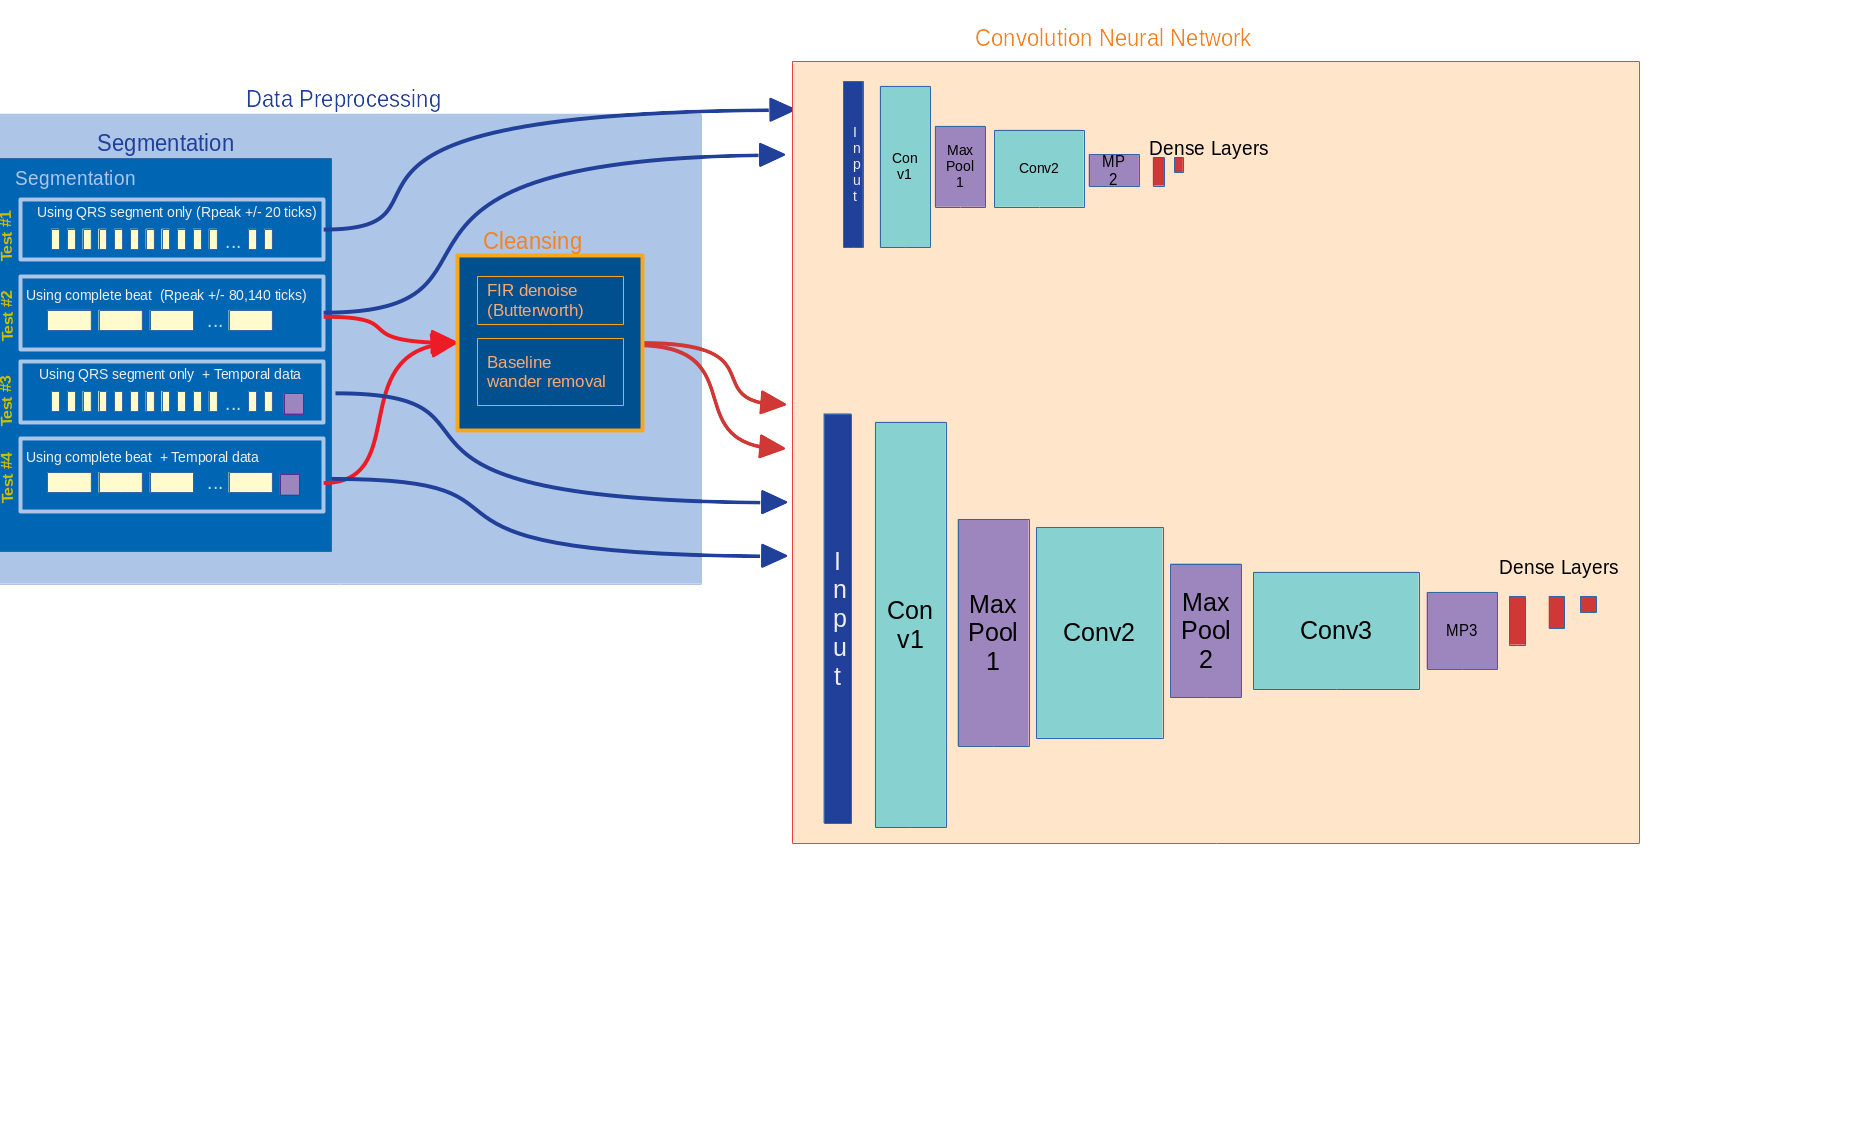

In [9]:
from IPython.display import Image
basewidth = 650
Image("img/flow.png")

### Summary of results

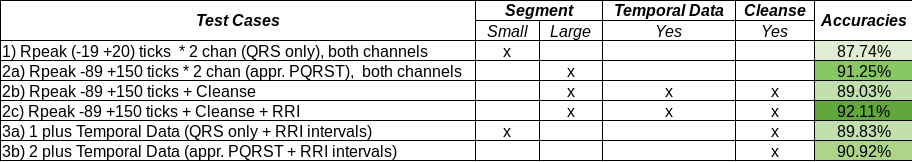

In [1]:
from IPython.display import Image
Image("img/ecg_results.png")

### 1) Using CNN on input:  Rpeak -19 / +20  ticks  (QRS only, both channels)

In [1]:
import os, sys
sys.path.append("./module")
import cnn_ecg as cnn_v1

##### Load up Dataset #1 (Classification) and Dataset #2 (Evaluation)  and create beat segments using inputs

In [2]:
# Set the length of the beat segment -> 40 ticks, appr. 1 QRS-interval

# MIT-BIH Patient ID's to Dataset mapping:
#
# Classification:
# DataSet #1 - 101, 106, 108, 109, 112, 114, 115, 116, 118, 119, 122, 124, 201, 203, 205, 207, 208, 209, 215, 220, 223, 230
#
# Evaluation:
# DataSet #2 - 100, 103, 105, 111, 113, 117, 121, 123, 200, 202, 210, 212, 213, 214, 219, 221, 222, 228, 231, 232, 233, 234
        
preX = 19
postX = 20
# Load DS1 - train and DS2 - eval datasets
ds1_all, ds1_ann, ds1_seg, ds1_lab = cnn_v1.create_DS("1",preX,postX)
ds2_all, ds2_ann, ds2_seg, ds2_lab = cnn_v1.create_DS("2",preX,postX)


##### Examples of beats obtained from MIT-BIH dataset

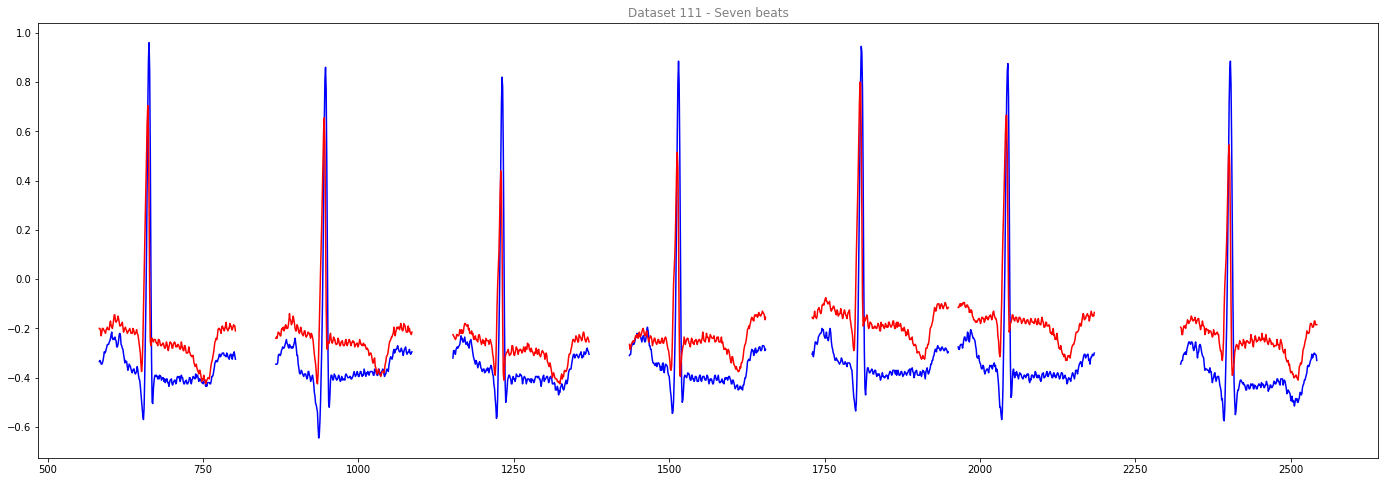

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

preX = 79;
postX = 140;
begNList = [];
endNList = [];
mixNList = [];
sliceNList = [];
    
for index, row in ds2_ann["100"].iterrows():
    Nbegin = row['sample'] - preX;
    Nend = row['sample'] + postX;
    begNList.append(Nbegin);
    endNList.append(Nend);

mixNList = tuple(zip(begNList,endNList)) 
#mixNList[-1]
        
plt.figure(figsize=(24,8))

for x in range(0,7):
    dfseg1 = ds2_all["100"][(ds2_all["100"]['sample'] >= mixNList[x][0]) & (ds2_all["100"]['sample'] <= mixNList[x][1])]
    plt.title('Dataset 111 - Seven beats', color="grey")
    plt.plot(dfseg1['MLII'], color="blue")
    plt.plot(dfseg1['V5'], color="red")

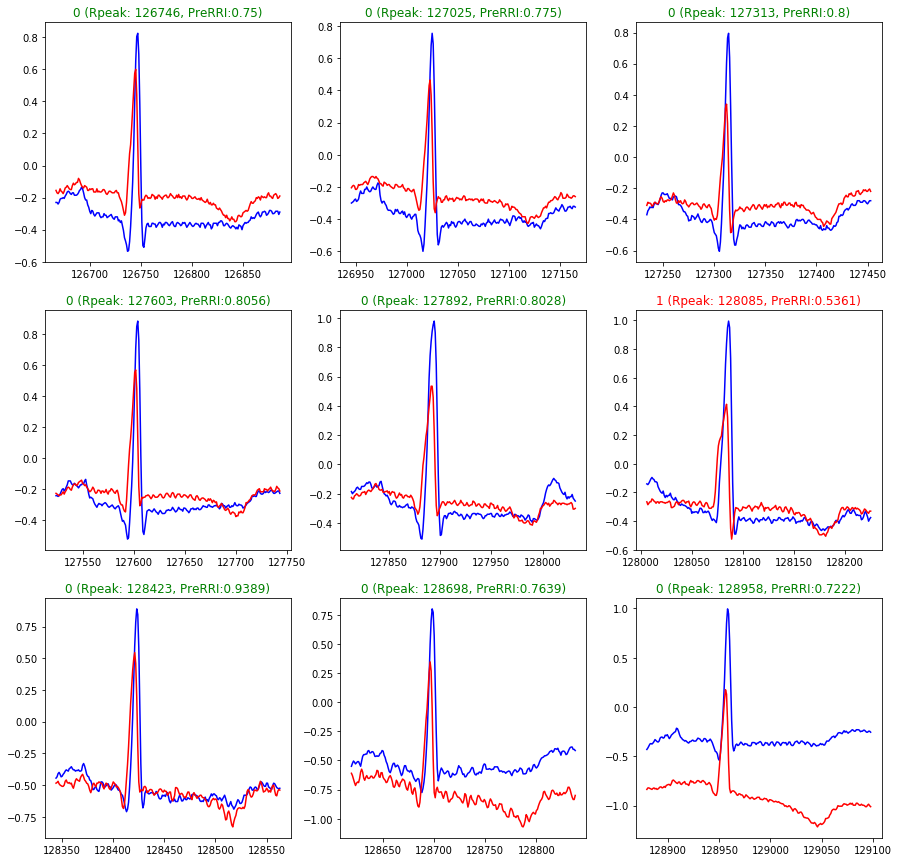

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, axes = plt.subplots(nrows=3, ncols=3, figsize = (15,15))

i = 434 # 20 115        
y = -1
for x in range(0,9):
    if x % 3 == 0:
        y=y+1
    dfseg1 = ds2_all["100"][(ds2_all["100"]['sample'] >= mixNList[x+i][0]) & (ds2_all["100"]['sample'] <= mixNList[x+i][1])]
    
    if str(ds2_ann["100"]['Type'][x+i+1]) != '0':
        axes[y, x % 3].set_title('my title', color="red")
    else:
        axes[y, x % 3].set_title('my title', color="green")
  
    axes[y, x % 3].plot(dfseg1['MLII'], color="blue")
    axes[y, x % 3].plot(dfseg1['V5'], color="red")
    axes[y, x % 3].set_title(str(ds2_ann["100"]['Type'][x+i+1]) + ' (Rpeak: ' + str(ds2_ann["100"]['sample'][x+i+1])  + ', PreRRI:' + str(float("{0:.4f}".format(ds2_ann["100"]['RRI'][x+i+1]))) +  ')' )


##### Create the training and evaluation data and labels

In [10]:
import numpy as np

# Prepare the input vectors as numpy arrays
train_data = ds1_seg
train_labels = np.asarray(ds1_lab, dtype=np.int32)
eval_data = ds2_seg
eval_labels = np.array(ds2_lab, dtype=np.int32)

# The total counts for all classes:
# Beat types:
# 0 - Normal beat  (N)
# 1 - Premature ventricular contraction (V)
# 2 - Atrial premature beat (SVEB)
# 3 - Fusion of ventricular and normal beat (F)
# 4 - Unclassifiable beat (Q)
print(np.unique(train_labels, return_counts=True))
print(np.unique(eval_labels, return_counts=True))



(array([0, 1, 2, 3, 4], dtype=int32), array([46077,   944,  4008,   414,   267]))
(array([0, 1, 2, 3, 4], dtype=int32), array([44486,  1837,  3225,   388,   745]))


##### Graph of convolutional network model used

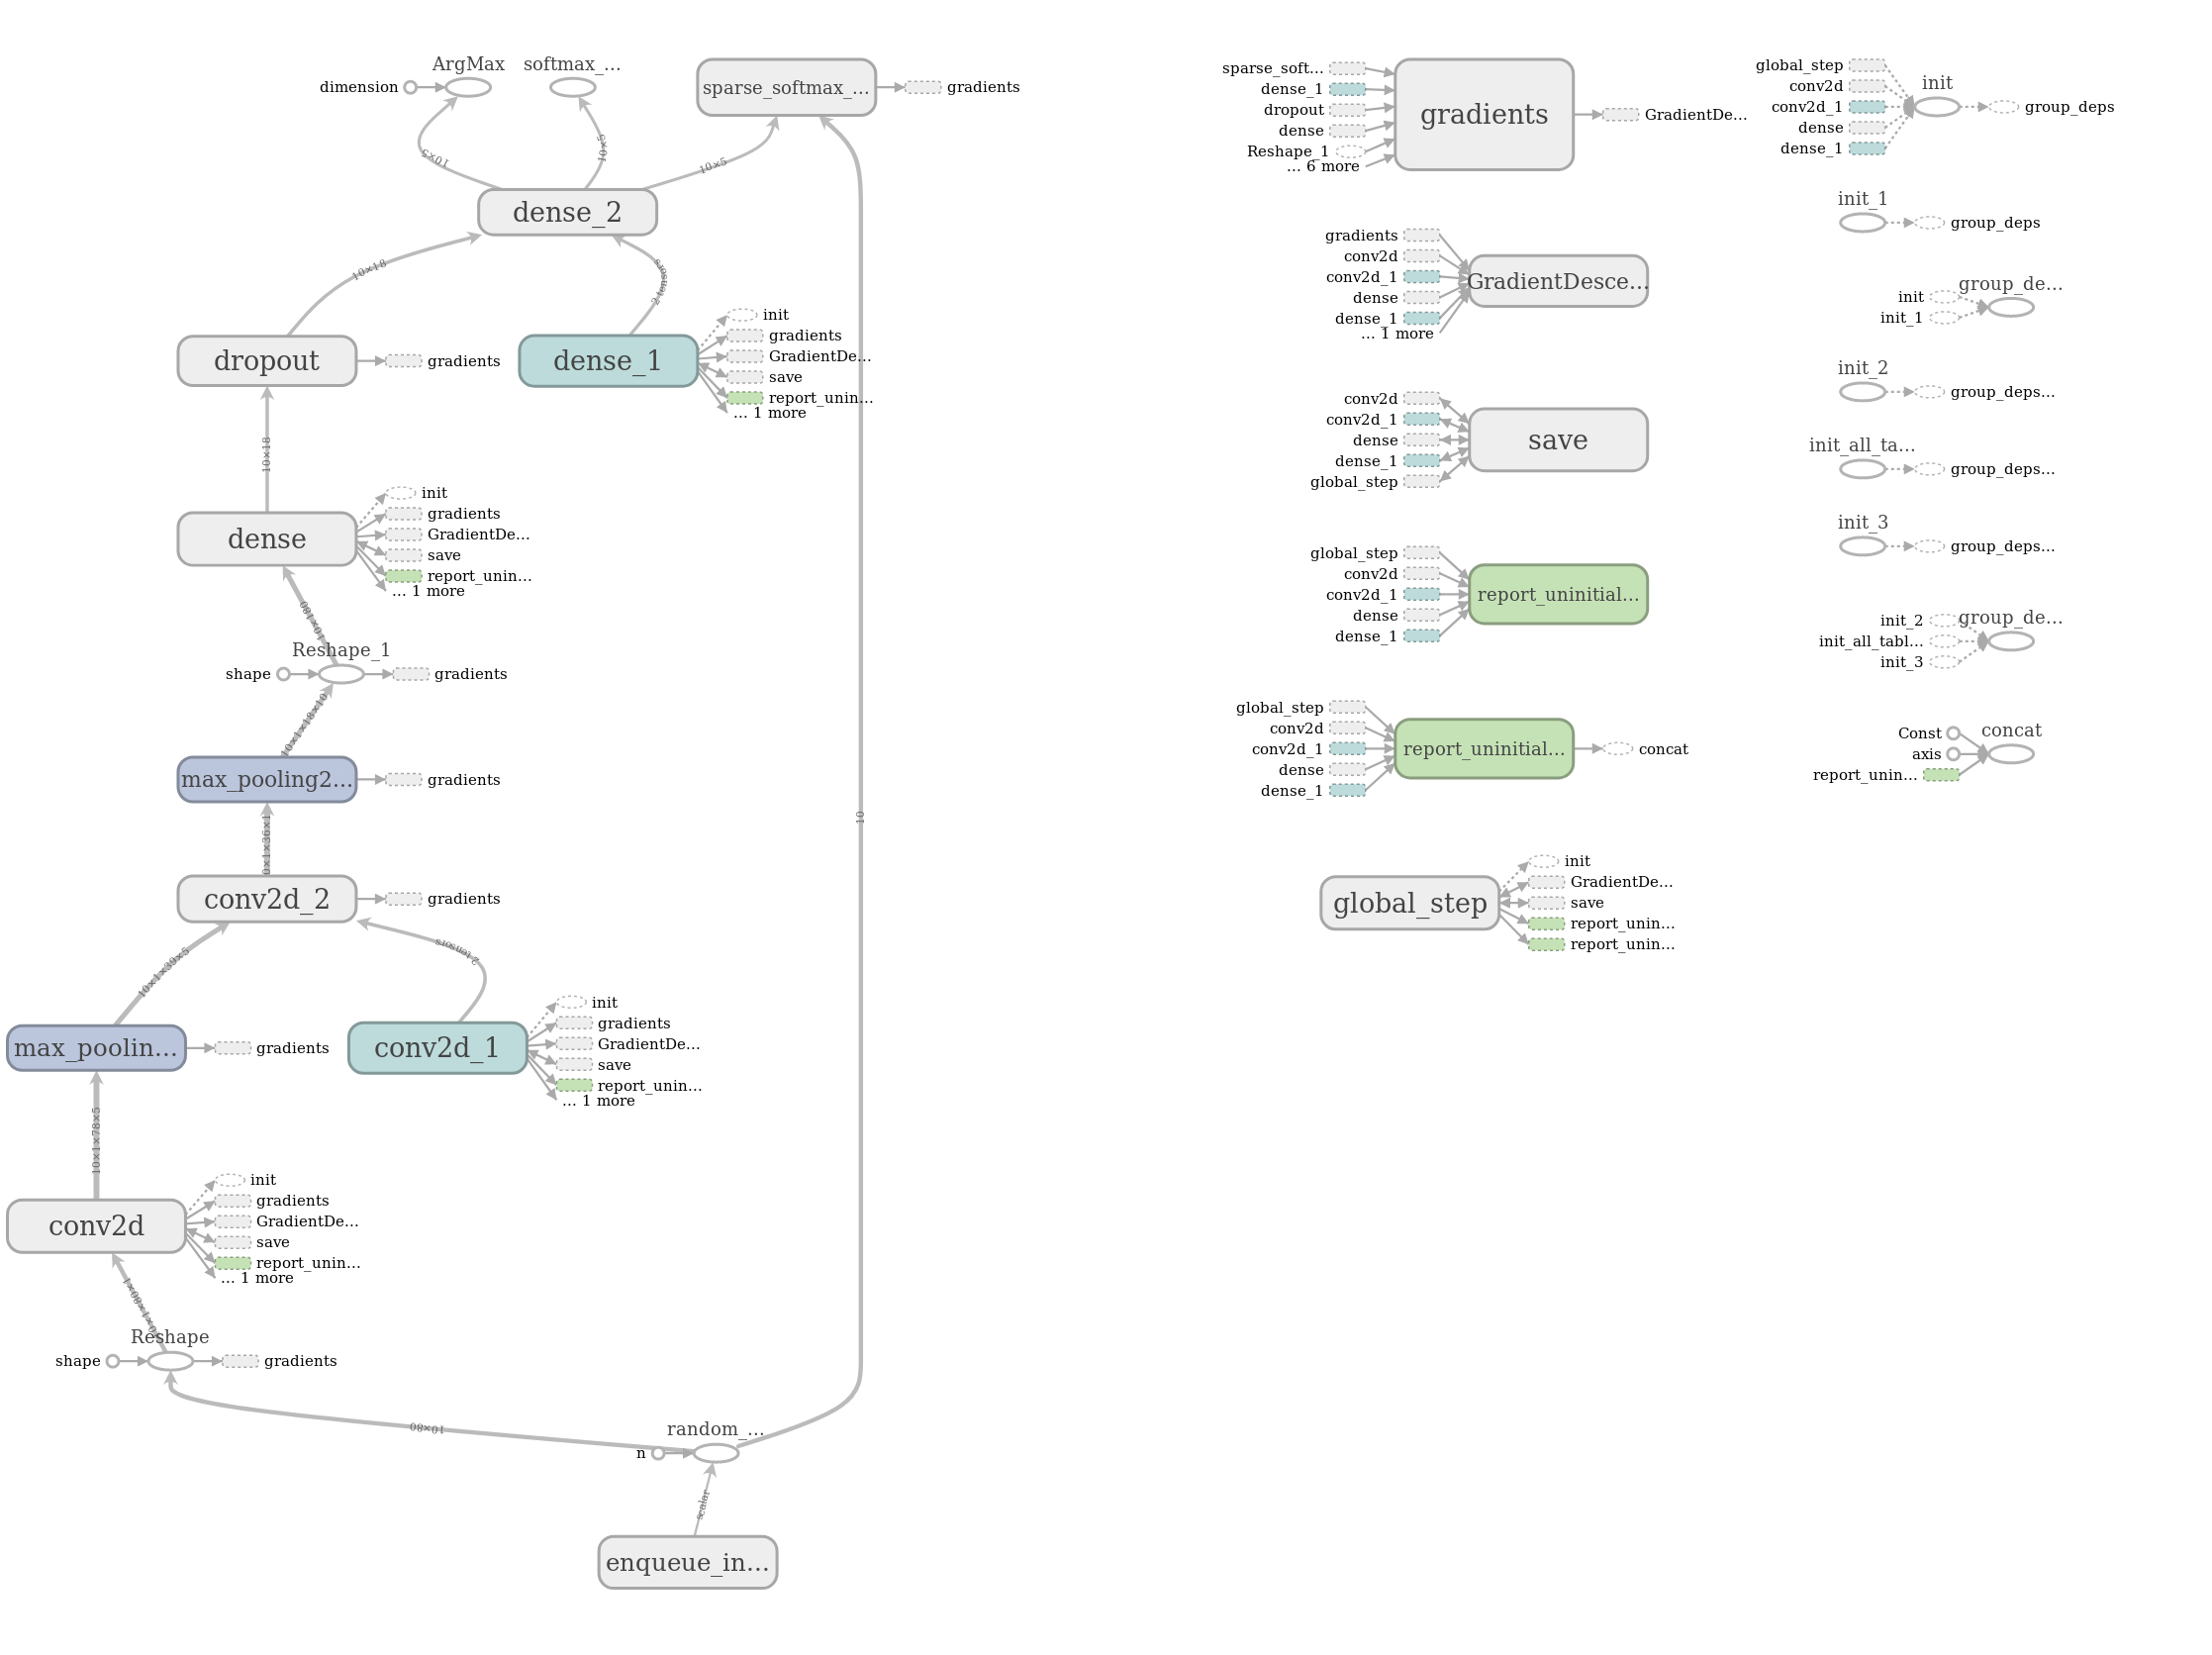

In [7]:
from IPython.display import Image
Image("img/cnn_v1.png")

##### Set up classifier and run the training of the network

In [ ]:
import tensorflow as tf

ecg_classifier = tf.estimator.Estimator(model_fn=cnn_v1.cnn_model_fn2, model_dir="/tmp/ecg_convnet_model2")
    
tensors_to_log = {"probabilities": "softmax_tensor"}
logging_hook = tf.train.LoggingTensorHook(tensors=tensors_to_log, every_n_iter=50)
    
# Train the model
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": train_data},
    y=train_labels,
    batch_size=10,
    num_epochs=None,
    shuffle=True)
ecg_classifier.train(
    input_fn=train_input_fn,
    steps=2000,
    hooks=[logging_hook])

##### Run evaluation of the model

In [9]:
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": eval_data},
    y=eval_labels,
    num_epochs=20,
    shuffle=False)
eval_results = ecg_classifier.evaluate(input_fn=eval_input_fn)
print(eval_results)
 

INFO:tensorflow:Starting evaluation at 2018-04-11-16:28:41
INFO:tensorflow:Restoring parameters from /tmp/ecg_convnet_model/model.ckpt-8000
INFO:tensorflow:Finished evaluation at 2018-04-11-16:28:55
INFO:tensorflow:Saving dict for global step 8000: accuracy = 0.90031767, global_step = 8000, loss = 0.41557667
{'accuracy': 0.90031767, 'loss': 0.41557667, 'global_step': 8000}


##### Result

In [ ]:
{'accuracy': 0.8783765, 'loss': 0.72681844, 'global_step': 6000}

### 2) Using CNN on input:  Rpeak -89 / +150  ticks  (appr. entire PQRST, both channels)

In [4]:

# Set the length of the beat segment -> 40 ticks, appr. 1 QRS-interval
preX = 89
postX = 150
# Load DS1 - train and DS2 - eval datasets
ds1_all, ds1_ann, ds1_seg, ds1_lab = cnn_v1.create_DS("1",preX,postX)
ds2_all, ds2_ann, ds2_seg, ds2_lab = cnn_v1.create_DS("2",preX,postX)

In [13]:
import numpy as np

# Prepare the input vectors as numpy arrays
train_data = ds1_seg
train_labels = np.asarray(ds1_lab, dtype=np.int32)
eval_data = ds2_seg
eval_labels = np.array(ds2_lab, dtype=np.int32)


##### Graph of convolutional network model used

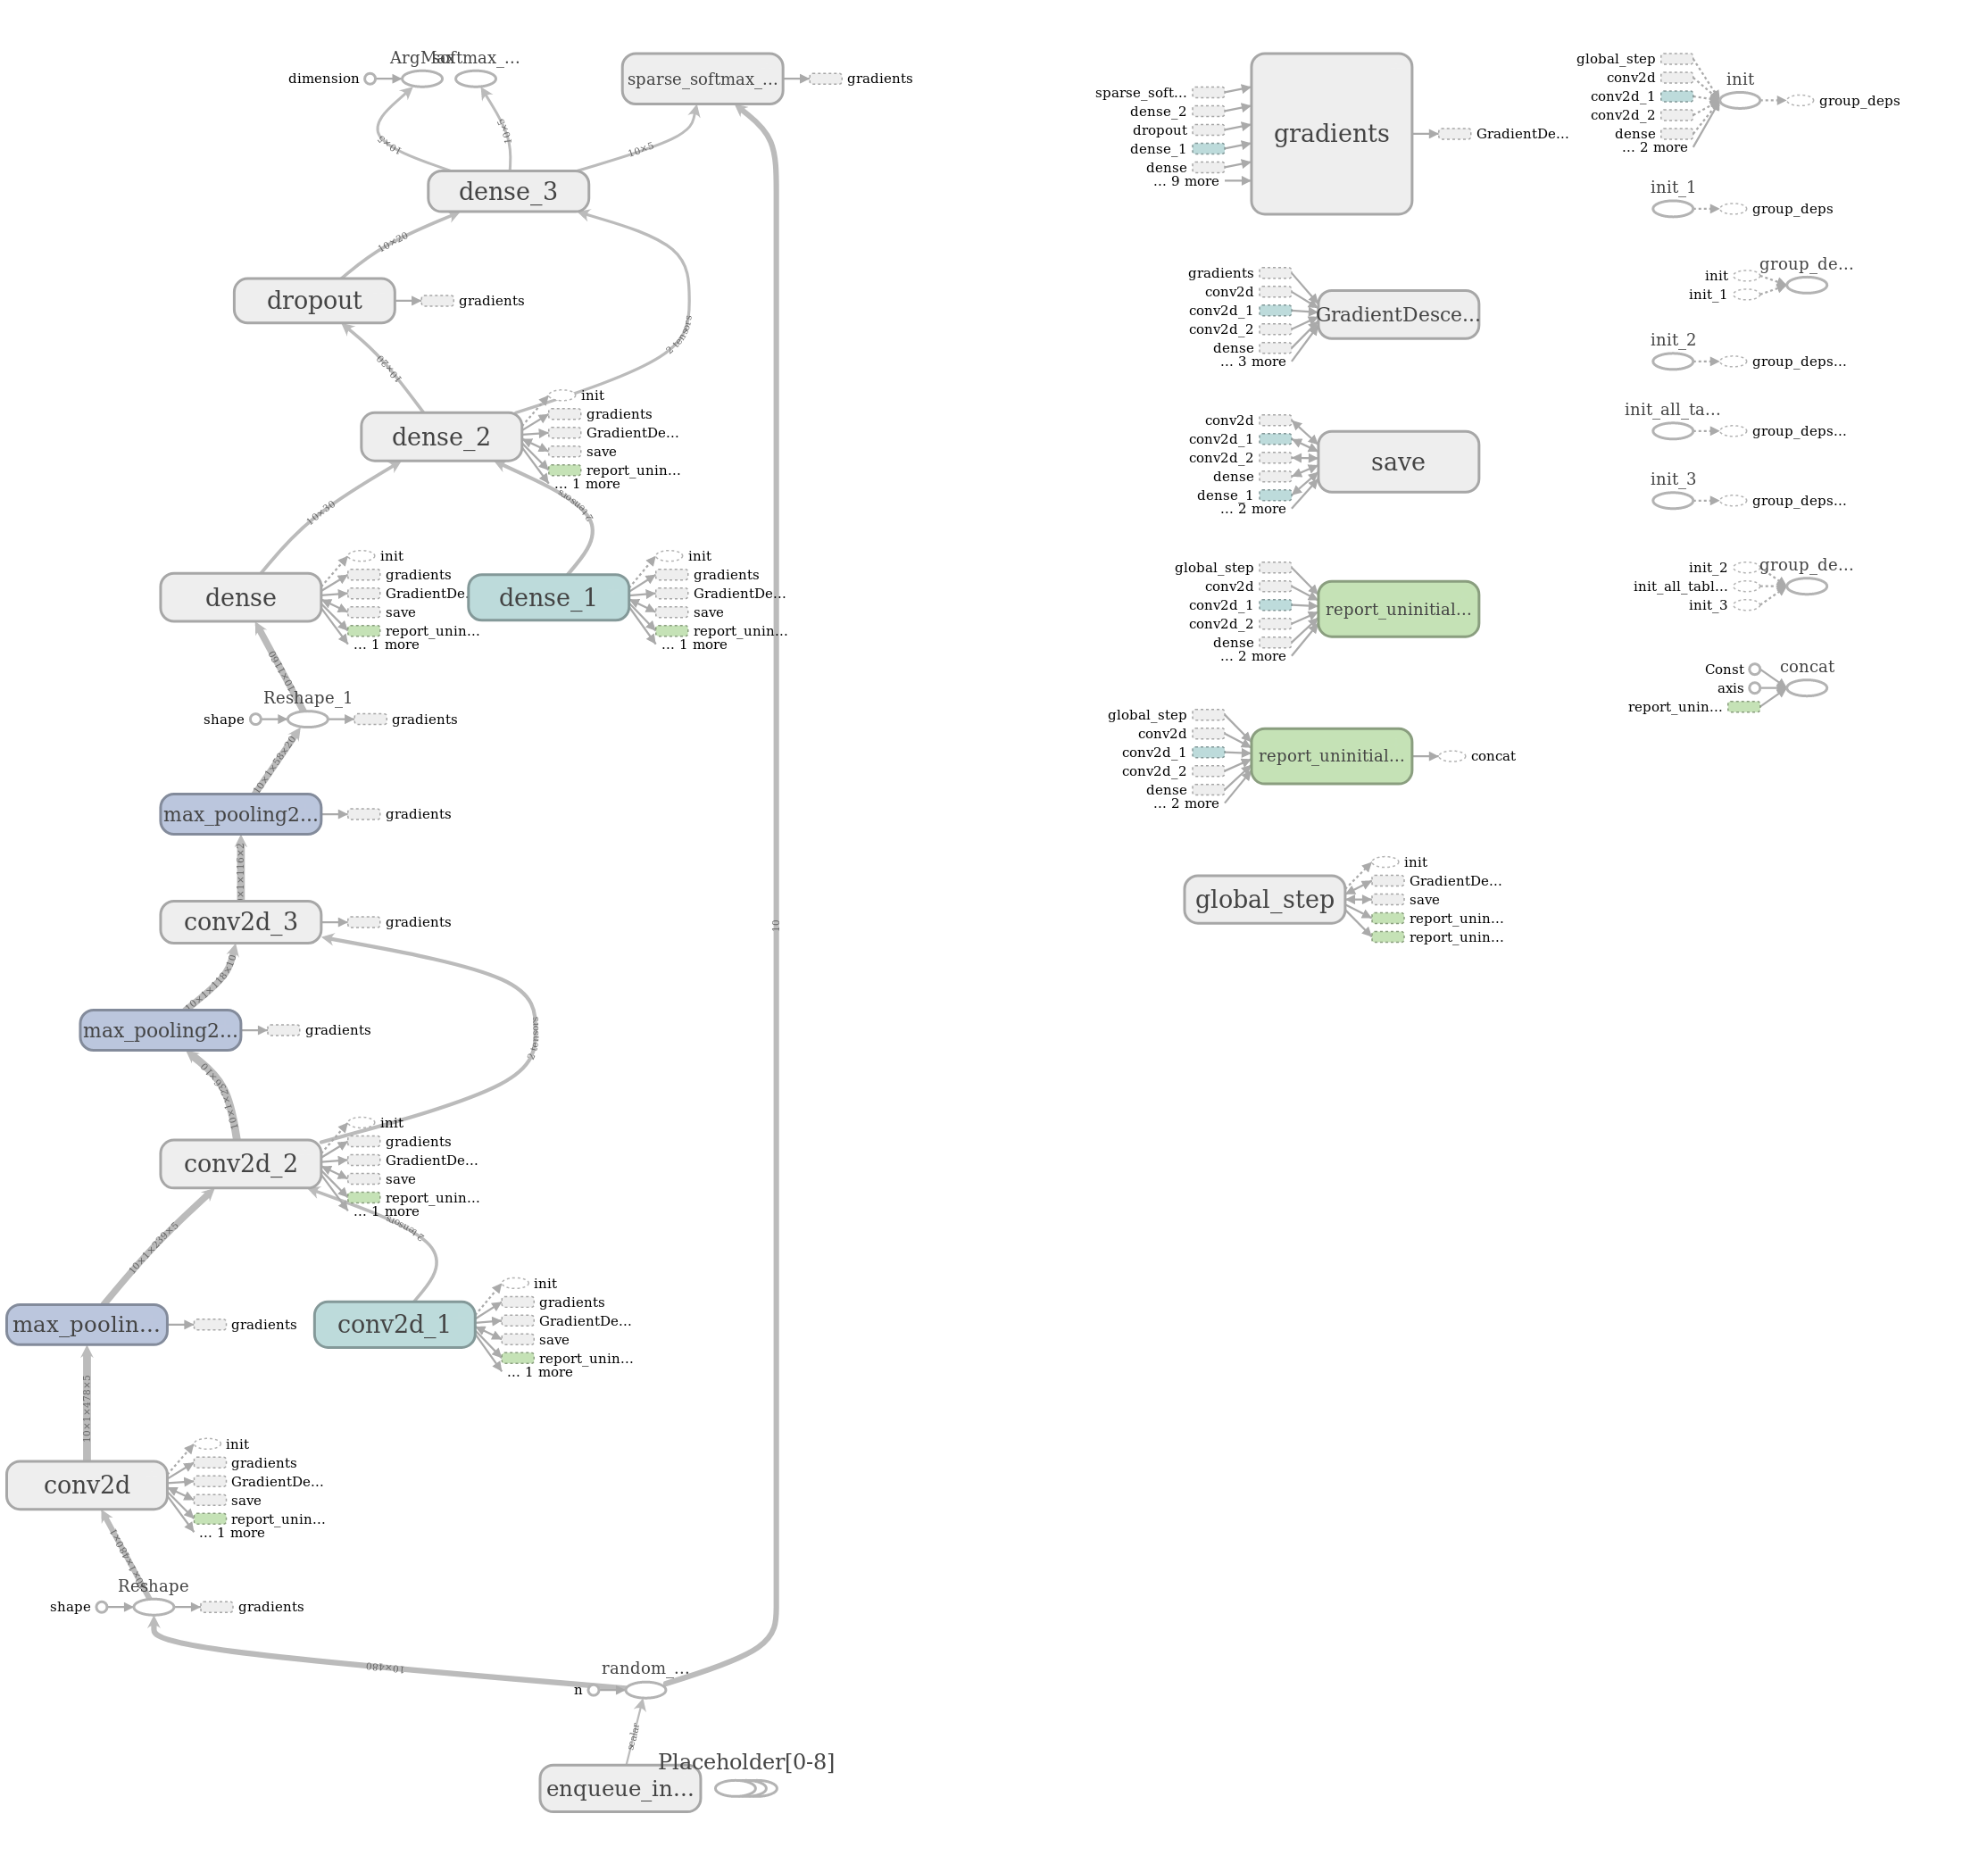

In [3]:
from IPython.display import Image
Image("img/cnn_v2.png")

##### Set up classifier and run the training of the network

##### Run evaluation of the model

In [ ]:
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": eval_data},
    y=eval_labels,
    num_epochs=20,
    shuffle=False)
eval_results = ecg_classifier.evaluate(input_fn=eval_input_fn)
print(eval_results)

##### Result

In [ ]:
{'accuracy': 0.91249186, 'loss': 0.48948607, 'global_step': 6440}

### 2b) Testing efficiency of data cleansing steps (Denoise + Baseline Wander removal)

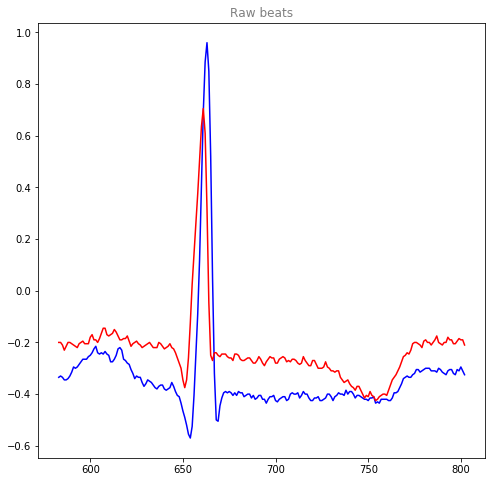

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

preX = 79;
postX = 140;
begNList = [];
endNList = [];
mixNList = [];
sliceNList = [];
    
for index, row in ds2_ann["100"].iterrows():
    Nbegin = row['sample'] - preX;
    Nend = row['sample'] + postX;
    begNList.append(Nbegin);
    endNList.append(Nend);

mixNList = tuple(zip(begNList,endNList)) 
#mixNList[-1]
        
plt.figure(figsize=(8,8))

for x in range(0,1):
    dfseg1 = ds2_all["100"][(ds2_all["100"]['sample'] >= mixNList[x][0]) & (ds2_all["100"]['sample'] <= mixNList[x][1])]
    plt.title('Raw beats', color="grey")
    plt.plot(dfseg1['MLII'], color="blue")
    plt.plot(dfseg1['V5'], color="red")

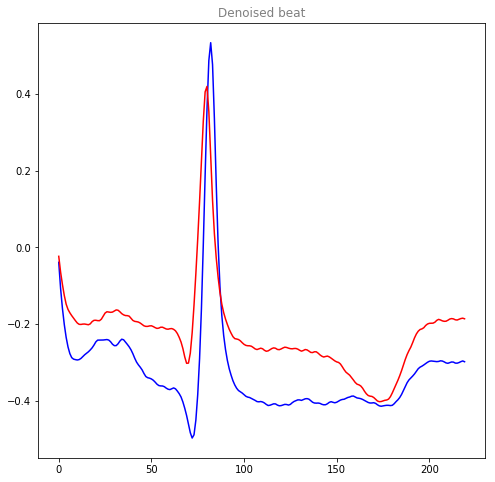

In [6]:
from scipy import signal

# Butterworth filter: x -> y
lowcut=0.01
highcut=15.0
signal_freq=360
filter_order=1
plt.figure(figsize=(10,10))
nyquist_freq = 0.5*signal_freq
low=lowcut/nyquist_freq
high=highcut/nyquist_freq

b, a = signal.butter(filter_order, [low,high], btype="band")


import matplotlib.pyplot as plt
%matplotlib inline

preX = 79;
postX = 140;
begNList = [];
endNList = [];
mixNList = [];
sliceNList = [];
    
for index, row in ds2_ann["100"].iterrows():
    Nbegin = row['sample'] - preX;
    Nend = row['sample'] + postX;
    begNList.append(Nbegin);
    endNList.append(Nend);

mixNList = tuple(zip(begNList,endNList)) 
#mixNList[-1]
        
plt.figure(figsize=(8,8))

for x in range(0,1):
    dfseg1 = ds2_all["100"][(ds2_all["100"]['sample'] >= mixNList[x][0]) & (ds2_all["100"]['sample'] <= mixNList[x][1])]
    y1 = signal.lfilter(b, a, dfseg1['MLII'])
    y2 = signal.lfilter(b, a, dfseg1['V5'])
    plt.title('Denoised beat', color="grey")
    plt.plot(y1, color="blue")
    plt.plot(y2, color="red")

##### Using the same network model as in 2), the achieved accuracy is:

In [ ]:
{'accuracy': 0.8903139, 'loss': 0.78278273, 'global_step': 8000}

In [2]:
# Set the length of the beat segment -> 40 ticks, appr. 1 QRS-interval
preX = 19
postX = 20
# Load DS1 - train and DS2 - eval datasets
ds1_all, ds1_ann, ds1_seg, ds1_lab = cnn_v1.create_DS("1",preX,postX)
#ds2_all, ds2_ann, ds2_seg, ds2_lab = cnn_v1.create_DS("2",preX,postX)

### 2c) Using CNN on input: Rpeak -89 / +150 ticks + Cleanse + Temporal Data (RRI Intervals)

Using the same CNN as in 2), but this time deploying the cnn_model_fn2_rri  model, which is a slight modification of the original model, taking care of the changed input dimension

In [ ]:
ds1_all, ds1_ann, ds1_seg, ds1_lab = create_DS("1",preX,postX,cleanse=True)
ds2_all, ds2_ann, ds2_seg, ds2_lab = create_DS("2",preX,postX,cleanse=True)
    
ecg_classifier = tf.estimator.Estimator(model_fn=cnn_model_fn2_rri, model_dir="/tmp/ecg_convnet_model2_rri")
    
    # Set up logging for predictions
    # Log the values in the "Softmax" tensor with label "probabilities"
    tensors_to_log = {"probabilities": "softmax_tensor"}
    logging_hook = tf.train.LoggingTensorHook(tensors=tensors_to_log, every_n_iter=50)
    
    # Train the model
    train_input_fn = tf.estimator.inputs.numpy_input_fn(
        x={"x": train_data},
        y=train_labels,
        batch_size=10,
        num_epochs=None,
        shuffle=True)
    ecg_classifier.train(
        input_fn=train_input_fn,
        steps=20000,
        hooks=[logging_hook])
    
    # Evaluate the model and print results
    eval_input_fn = tf.estimator.inputs.numpy_input_fn(
        x={"x": eval_data},
        y=eval_labels,
        num_epochs=20,
        shuffle=False)
    eval_results = ecg_classifier.evaluate(input_fn=eval_input_fn)
    print(eval_results)

##### Result

In [ ]:
{'accuracy': 0.92111444, 'loss': 0.48581737, 'global_step': 80000}

### 3a) Using CNN on input:  Rpeak -19 / +20  ticks  (QRS only, both channels) + Temporal Data (RRI Intervals)

Using the same CNN as in 1), but this time deploying the cnn_model_fn_rri  model, which is a slight modification of the original model, taking care of the changed input dimension

In [ ]:
   ecg_classifier = tf.estimator.Estimator(model_fn=cnn_model_fn_rri, model_dir="/tmp/ecg_convnet_model_rri")
    
    tensors_to_log = {"probabilities": "softmax_tensor"}
    logging_hook = tf.train.LoggingTensorHook(tensors=tensors_to_log, every_n_iter=50)
    
    # Train the model
    train_input_fn = tf.estimator.inputs.numpy_input_fn(
        x={"x": train_data},
        y=train_labels,
        batch_size=10,
        num_epochs=None,
        shuffle=True)
    ecg_classifier.train(
        input_fn=train_input_fn,
        steps=20000,
        hooks=[logging_hook])
    
    # Evaluate the model and print results
    eval_input_fn = tf.estimator.inputs.numpy_input_fn(
        x={"x": eval_data},
        y=eval_labels,
        num_epochs=20,
        shuffle=False)
    eval_results = ecg_classifier.evaluate(input_fn=eval_input_fn)
    print(eval_results)

##### Result

In [ ]:
{'accuracy': 0.8992719, 'loss': 0.46288955, 'global_step': 22000}

### 3b) Using CNN on input:  Rpeak -89 / +150  ticks  (appr. 1 beat, both channels) + Temporal Data (RRI Intervals)

Using the same CNN as in 2), but this time deploying the cnn_model_fn2_rri  model, which is a slight modification of the original model, taking care of the changed input dimension. No cleansing is used.

In [ ]:
ds1_all, ds1_ann, ds1_seg, ds1_lab = create_DS("1",preX,postX,cleanse=False)
ds2_all, ds2_ann, ds2_seg, ds2_lab = create_DS("2",preX,postX,cleanse=False)
    
ecg_classifier = tf.estimator.Estimator(model_fn=cnn_model_fn2_rri, model_dir="/tmp/ecg_convnet_model2_rri")
    
    # Set up logging for predictions
    # Log the values in the "Softmax" tensor with label "probabilities"
    tensors_to_log = {"probabilities": "softmax_tensor"}
    logging_hook = tf.train.LoggingTensorHook(tensors=tensors_to_log, every_n_iter=50)
    
    # Train the model
    train_input_fn = tf.estimator.inputs.numpy_input_fn(
        x={"x": train_data},
        y=train_labels,
        batch_size=10,
        num_epochs=None,
        shuffle=True)
    ecg_classifier.train(
        input_fn=train_input_fn,
        steps=20000,
        hooks=[logging_hook])
    
    # Evaluate the model and print results
    eval_input_fn = tf.estimator.inputs.numpy_input_fn(
        x={"x": eval_data},
        y=eval_labels,
        num_epochs=20,
        shuffle=False)
    eval_results = ecg_classifier.evaluate(input_fn=eval_input_fn)
    print(eval_results)

##### Result

In [ ]:
{'accuracy': 0.9091573, 'loss': 0.8182358, 'global_step': 60000}